### Prisioner's Dilemma (Single Agent)

- There is a single agent that interact in repeated prisioner's dilemma. 
- Actions are: defect (D/0) or confess (C/1).
- There is one state that is the other bot's last play (this is memory).
- The other agent is just a deterministic bot (plays tit-for-tat or grim trigger)
- Rewards for agents are 

    - (3,3) for (D,D) 
    - (0,5) for (D,C) 
    - (5,0) for (C,D) 
    - (1,1) for (C,C)

- There is "discounting". Agents do value future profits.
- We simulate 3 scenarios:
    - Deterministic bot plays C only
    - Deterministic bot plays D only
    - Deterministic bot plays Tit-for-tat

### Import Packages

In [40]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Helper Functions

In [72]:
def gameReward(a1,a2):
    if (a1 == 0 and a2 == 0): # DD
        return (4.8,4.8)
    if (a1 == 0 and a2 == 1): # DC
        return (0,5)
    if (a1 == 1 and a2 == 0): # CD
        return (5,0)
    if (a1 == 1 and a2 == 1): # CD
        return (0.2,0.2)
   
def deterministicBot(a1_old):
    if (a1_old == 0): 
        return 0
    if (a1_old == 1): 
        return 1
    
import random
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state','next_state','a1','a2','r1','r2'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self,*args):
        "save transition"
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    # Input: State, Output: Value of actions (0/1)
    # Network predicts the expected Return of taking each action given the state
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)   


def select_action(state, policy_net, idx):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    if idx == 0:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done1/EPS_DECAY)
        steps_done1 += 1
    else:
        eps_threshold = EPS_END + (EPS_START-EPS_END)*math.exp(-1.*steps_done2/EPS_DECAY)
        steps_done2 += 1
    
    if sample>eps_threshold:
        with torch.no_grad():
            try: 
                return policy_net(state).max(1)[1].view(1,1) # pick up action with largest expected reward
            except:
                return policy_net(state).max(0)[1].view(1,1) # pick up action with largest expected reward
    else:
        randchoice = random.choice([0,1])
        return torch.tensor([[randchoice]],dtype=torch.long)
    
def update_target_net(target_net, policy_net):
    target_net_state_dict = target_net.state_dict()
    policy_net_state_dict = policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*TAU+target_net_state_dict[key]*(1-TAU)
    target_net.load_state_dict(target_net_state_dict)

def optimize_model(policy_net,target_net,idx):
    if len(memory)<BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # we begin with a batch of transitions - (state, action, reward)
    state_batch = torch.cat(batch.state)
    if idx == 0:
        action_batch = torch.cat(batch.a1)
        reward_batch = torch.cat(batch.r1)
    elif idx == 1:
        action_batch = torch.cat(batch.a2)
        reward_batch = torch.cat(batch.r2)
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = policy_net(state_batch.reshape(-1,1)).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = target_net(non_final_next_states.reshape(-1,1)).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    if idx == 0:
        optimizer1.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net1.parameters(),100)
        optimizer1.step()
    elif idx == 1:
        optimizer2.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(policy_net2.parameters(),100)
        optimizer2.step()
    print(f'Loss Agent{idx}:{loss.item()}')
        
    

### HyperParameters and Initializations

In [73]:
BATCH_SIZE = 128 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon (Exploration)
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
n_obs = 1
n_actions = 2
policy_net1 = DQN(n_obs,n_actions)
target_net1 = DQN(n_obs,n_actions)
steps_done1 = 0
optimizer1 = optim.AdamW(policy_net1.parameters(),lr=LR,amsgrad=True)
memory=ReplayMemory(10000)

### Training Loop

In [74]:
state = torch.tensor(1,dtype=torch.float32).unsqueeze(0)
actions = []
epochs = 10000

state = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)
a1 = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)

for t in range(epochs):
    print('\n Iteration:',t)
    
    # Take action
    a2 = deterministicBot(int(a1)) # bot takes action based off past policy
    a1 = select_action(state, policy_net1, 0)

    # Obtain Rewards
    r1, r2 = gameReward(int(a1),int(a2))
    r1 = torch.tensor([r1])

    # Compute next state (which is the opponents' strategy)
    next_state = torch.tensor(int(a2),dtype=torch.float32).unsqueeze(0)

    # store memory in transition
    memory.push(state,next_state,a1,a2,r1,r2)

    # move to next state
    state = next_state

    # optimize
    optimize_model(policy_net1,target_net1, 0)

    # soft update target_net
    update_target_net(target_net1, policy_net1)
    
    # record actions
    actions.append([int(a1),int(a2)])


 Iteration: 0

 Iteration: 1

 Iteration: 2

 Iteration: 3

 Iteration: 4

 Iteration: 5

 Iteration: 6

 Iteration: 7

 Iteration: 8

 Iteration: 9

 Iteration: 10

 Iteration: 11

 Iteration: 12

 Iteration: 13

 Iteration: 14

 Iteration: 15

 Iteration: 16

 Iteration: 17

 Iteration: 18

 Iteration: 19

 Iteration: 20

 Iteration: 21

 Iteration: 22

 Iteration: 23

 Iteration: 24

 Iteration: 25

 Iteration: 26

 Iteration: 27

 Iteration: 28

 Iteration: 29

 Iteration: 30

 Iteration: 31

 Iteration: 32

 Iteration: 33

 Iteration: 34

 Iteration: 35

 Iteration: 36

 Iteration: 37

 Iteration: 38

 Iteration: 39

 Iteration: 40

 Iteration: 41

 Iteration: 42

 Iteration: 43

 Iteration: 44

 Iteration: 45

 Iteration: 46

 Iteration: 47

 Iteration: 48

 Iteration: 49

 Iteration: 50

 Iteration: 51

 Iteration: 52

 Iteration: 53

 Iteration: 54

 Iteration: 55

 Iteration: 56

 Iteration: 57

 Iteration: 58

 Iteration: 59

 Iteration: 60

 Iteration: 61

 Iteration: 62

 

Loss Agent0:1.7784861326217651

 Iteration: 286
Loss Agent0:1.6803314685821533

 Iteration: 287
Loss Agent0:1.65695059299469

 Iteration: 288
Loss Agent0:1.6304662227630615

 Iteration: 289
Loss Agent0:1.6640944480895996

 Iteration: 290
Loss Agent0:1.7330642938613892

 Iteration: 291
Loss Agent0:1.754878282546997

 Iteration: 292
Loss Agent0:1.5334100723266602

 Iteration: 293
Loss Agent0:1.736085057258606

 Iteration: 294
Loss Agent0:1.734827995300293

 Iteration: 295
Loss Agent0:1.7069586515426636

 Iteration: 296
Loss Agent0:1.3795312643051147

 Iteration: 297
Loss Agent0:1.5107464790344238

 Iteration: 298
Loss Agent0:1.6814583539962769

 Iteration: 299
Loss Agent0:1.6295524835586548

 Iteration: 300
Loss Agent0:1.766754150390625

 Iteration: 301
Loss Agent0:1.6756799221038818

 Iteration: 302
Loss Agent0:1.5602450370788574

 Iteration: 303
Loss Agent0:1.7346014976501465

 Iteration: 304
Loss Agent0:1.5242708921432495

 Iteration: 305
Loss Agent0:1.7144575119018555

 Iteration: 30

Loss Agent0:1.7308931350708008

 Iteration: 488
Loss Agent0:2.0105013847351074

 Iteration: 489
Loss Agent0:1.6552600860595703

 Iteration: 490
Loss Agent0:1.7207506895065308

 Iteration: 491
Loss Agent0:1.6624274253845215

 Iteration: 492
Loss Agent0:1.6282505989074707

 Iteration: 493
Loss Agent0:1.699404239654541

 Iteration: 494
Loss Agent0:1.696948528289795

 Iteration: 495
Loss Agent0:1.6981579065322876

 Iteration: 496
Loss Agent0:1.7287710905075073

 Iteration: 497
Loss Agent0:1.5237802267074585

 Iteration: 498
Loss Agent0:1.6011427640914917

 Iteration: 499
Loss Agent0:1.7488980293273926

 Iteration: 500
Loss Agent0:1.7036280632019043

 Iteration: 501
Loss Agent0:1.7646342515945435

 Iteration: 502
Loss Agent0:1.6672232151031494

 Iteration: 503
Loss Agent0:1.8938076496124268

 Iteration: 504
Loss Agent0:1.6002931594848633

 Iteration: 505
Loss Agent0:1.6425204277038574

 Iteration: 506
Loss Agent0:1.5569241046905518

 Iteration: 507
Loss Agent0:1.8231582641601562

 Iteration

Loss Agent0:1.7087750434875488

 Iteration: 669
Loss Agent0:1.6380417346954346

 Iteration: 670
Loss Agent0:1.7745821475982666

 Iteration: 671
Loss Agent0:1.7957253456115723

 Iteration: 672
Loss Agent0:1.8863343000411987

 Iteration: 673
Loss Agent0:1.919594407081604

 Iteration: 674
Loss Agent0:1.858117699623108

 Iteration: 675
Loss Agent0:1.6076109409332275

 Iteration: 676
Loss Agent0:1.6455267667770386

 Iteration: 677
Loss Agent0:1.7523093223571777

 Iteration: 678
Loss Agent0:1.6281471252441406

 Iteration: 679
Loss Agent0:1.4599252939224243

 Iteration: 680
Loss Agent0:1.7885525226593018

 Iteration: 681
Loss Agent0:1.6896307468414307

 Iteration: 682
Loss Agent0:1.6960371732711792

 Iteration: 683
Loss Agent0:1.7681878805160522

 Iteration: 684
Loss Agent0:1.4038606882095337

 Iteration: 685
Loss Agent0:1.606263518333435

 Iteration: 686
Loss Agent0:1.8867225646972656

 Iteration: 687
Loss Agent0:1.6504135131835938

 Iteration: 688
Loss Agent0:2.0548453330993652

 Iteration:

Loss Agent0:1.7479959726333618

 Iteration: 856
Loss Agent0:1.9868123531341553

 Iteration: 857
Loss Agent0:1.681131362915039

 Iteration: 858
Loss Agent0:1.8037725687026978

 Iteration: 859
Loss Agent0:1.6067789793014526

 Iteration: 860
Loss Agent0:1.8986696004867554

 Iteration: 861
Loss Agent0:1.892887830734253

 Iteration: 862
Loss Agent0:1.6474015712738037

 Iteration: 863
Loss Agent0:1.8221567869186401

 Iteration: 864
Loss Agent0:1.923279047012329

 Iteration: 865
Loss Agent0:1.8644312620162964

 Iteration: 866
Loss Agent0:1.835644245147705

 Iteration: 867
Loss Agent0:1.7485110759735107

 Iteration: 868
Loss Agent0:1.9080606698989868

 Iteration: 869
Loss Agent0:1.8049085140228271

 Iteration: 870
Loss Agent0:1.844305157661438

 Iteration: 871
Loss Agent0:1.994966983795166

 Iteration: 872
Loss Agent0:1.562621831893921

 Iteration: 873
Loss Agent0:2.0071897506713867

 Iteration: 874
Loss Agent0:1.7885223627090454

 Iteration: 875
Loss Agent0:1.916693091392517

 Iteration: 876


Loss Agent0:1.7327829599380493

 Iteration: 1033
Loss Agent0:1.9190465211868286

 Iteration: 1034
Loss Agent0:1.8236018419265747

 Iteration: 1035
Loss Agent0:1.8068791627883911

 Iteration: 1036
Loss Agent0:1.8124377727508545

 Iteration: 1037
Loss Agent0:1.9030681848526

 Iteration: 1038
Loss Agent0:1.9182380437850952

 Iteration: 1039
Loss Agent0:1.8278576135635376

 Iteration: 1040
Loss Agent0:1.8021650314331055

 Iteration: 1041
Loss Agent0:1.8525340557098389

 Iteration: 1042
Loss Agent0:1.7146824598312378

 Iteration: 1043
Loss Agent0:1.8876911401748657

 Iteration: 1044
Loss Agent0:1.7186739444732666

 Iteration: 1045
Loss Agent0:1.8901877403259277

 Iteration: 1046
Loss Agent0:1.7952607870101929

 Iteration: 1047
Loss Agent0:1.776233196258545

 Iteration: 1048
Loss Agent0:1.6683447360992432

 Iteration: 1049
Loss Agent0:1.756759524345398

 Iteration: 1050
Loss Agent0:1.670691728591919

 Iteration: 1051
Loss Agent0:1.7981027364730835

 Iteration: 1052
Loss Agent0:1.766550779342


 Iteration: 1212
Loss Agent0:1.4949932098388672

 Iteration: 1213
Loss Agent0:1.653637409210205

 Iteration: 1214
Loss Agent0:1.6968660354614258

 Iteration: 1215
Loss Agent0:1.4644272327423096

 Iteration: 1216
Loss Agent0:1.535051703453064

 Iteration: 1217
Loss Agent0:1.7148405313491821

 Iteration: 1218
Loss Agent0:1.672263741493225

 Iteration: 1219
Loss Agent0:1.8657995462417603

 Iteration: 1220
Loss Agent0:1.511770486831665

 Iteration: 1221
Loss Agent0:1.6449124813079834

 Iteration: 1222
Loss Agent0:1.6614656448364258

 Iteration: 1223
Loss Agent0:1.535547137260437

 Iteration: 1224
Loss Agent0:1.886542797088623

 Iteration: 1225
Loss Agent0:1.6431821584701538

 Iteration: 1226
Loss Agent0:1.7881038188934326

 Iteration: 1227
Loss Agent0:1.4686671495437622

 Iteration: 1228
Loss Agent0:1.6185258626937866

 Iteration: 1229
Loss Agent0:1.6675429344177246

 Iteration: 1230
Loss Agent0:1.8044960498809814

 Iteration: 1231
Loss Agent0:1.715221881866455

 Iteration: 1232
Loss Agen

Loss Agent0:1.8404102325439453

 Iteration: 1382
Loss Agent0:1.5670737028121948

 Iteration: 1383
Loss Agent0:1.5170379877090454

 Iteration: 1384
Loss Agent0:1.4417643547058105

 Iteration: 1385
Loss Agent0:1.5922249555587769

 Iteration: 1386
Loss Agent0:1.38718843460083

 Iteration: 1387
Loss Agent0:1.5457968711853027

 Iteration: 1388
Loss Agent0:1.6495025157928467

 Iteration: 1389
Loss Agent0:1.473926305770874

 Iteration: 1390
Loss Agent0:1.6647616624832153

 Iteration: 1391
Loss Agent0:1.525172233581543

 Iteration: 1392
Loss Agent0:1.5365805625915527

 Iteration: 1393
Loss Agent0:1.5187652111053467

 Iteration: 1394
Loss Agent0:1.6135523319244385

 Iteration: 1395
Loss Agent0:1.6572785377502441

 Iteration: 1396
Loss Agent0:1.563028335571289

 Iteration: 1397
Loss Agent0:1.6970115900039673

 Iteration: 1398
Loss Agent0:1.5600601434707642

 Iteration: 1399
Loss Agent0:1.4986481666564941

 Iteration: 1400
Loss Agent0:1.6217694282531738

 Iteration: 1401
Loss Agent0:1.39025723934

Loss Agent0:1.3838489055633545

 Iteration: 1564
Loss Agent0:1.528692364692688

 Iteration: 1565
Loss Agent0:1.4492626190185547

 Iteration: 1566
Loss Agent0:1.2931416034698486

 Iteration: 1567
Loss Agent0:1.271880865097046

 Iteration: 1568
Loss Agent0:1.533058762550354

 Iteration: 1569
Loss Agent0:1.319550633430481

 Iteration: 1570
Loss Agent0:1.090248942375183

 Iteration: 1571
Loss Agent0:1.5670087337493896

 Iteration: 1572
Loss Agent0:1.35871160030365

 Iteration: 1573
Loss Agent0:1.385604739189148

 Iteration: 1574
Loss Agent0:1.6072719097137451

 Iteration: 1575
Loss Agent0:1.292872428894043

 Iteration: 1576
Loss Agent0:1.3808172941207886

 Iteration: 1577
Loss Agent0:1.4553900957107544

 Iteration: 1578
Loss Agent0:1.396096110343933

 Iteration: 1579
Loss Agent0:1.5220400094985962

 Iteration: 1580
Loss Agent0:1.2687805891036987

 Iteration: 1581
Loss Agent0:1.8264048099517822

 Iteration: 1582
Loss Agent0:1.4005740880966187

 Iteration: 1583
Loss Agent0:1.4079426527023315

Loss Agent0:1.3269129991531372

 Iteration: 1743
Loss Agent0:1.135535717010498

 Iteration: 1744
Loss Agent0:1.3361996412277222

 Iteration: 1745
Loss Agent0:1.2106373310089111

 Iteration: 1746
Loss Agent0:1.4758647680282593

 Iteration: 1747
Loss Agent0:1.4664908647537231

 Iteration: 1748
Loss Agent0:1.302365779876709

 Iteration: 1749
Loss Agent0:1.1948273181915283

 Iteration: 1750
Loss Agent0:1.3595221042633057

 Iteration: 1751
Loss Agent0:1.136365532875061

 Iteration: 1752
Loss Agent0:1.2098629474639893

 Iteration: 1753
Loss Agent0:1.363099217414856

 Iteration: 1754
Loss Agent0:1.416368842124939

 Iteration: 1755
Loss Agent0:1.3196637630462646

 Iteration: 1756
Loss Agent0:1.3441694974899292

 Iteration: 1757
Loss Agent0:1.3462519645690918

 Iteration: 1758
Loss Agent0:1.232224941253662

 Iteration: 1759
Loss Agent0:1.4257309436798096

 Iteration: 1760
Loss Agent0:1.2295863628387451

 Iteration: 1761
Loss Agent0:1.4697176218032837

 Iteration: 1762
Loss Agent0:1.460031151771

Loss Agent0:1.0461337566375732

 Iteration: 1921
Loss Agent0:1.1377315521240234

 Iteration: 1922
Loss Agent0:1.4316457509994507

 Iteration: 1923
Loss Agent0:1.2318943738937378

 Iteration: 1924
Loss Agent0:1.2252553701400757

 Iteration: 1925
Loss Agent0:1.3425527811050415

 Iteration: 1926
Loss Agent0:1.1171892881393433

 Iteration: 1927
Loss Agent0:1.1316242218017578

 Iteration: 1928
Loss Agent0:1.1669470071792603

 Iteration: 1929
Loss Agent0:1.4144110679626465

 Iteration: 1930
Loss Agent0:1.2860974073410034

 Iteration: 1931
Loss Agent0:1.1153885126113892

 Iteration: 1932
Loss Agent0:1.2069309949874878

 Iteration: 1933
Loss Agent0:1.2697582244873047

 Iteration: 1934
Loss Agent0:1.3423876762390137

 Iteration: 1935
Loss Agent0:1.2431750297546387

 Iteration: 1936
Loss Agent0:0.9627757668495178

 Iteration: 1937
Loss Agent0:1.4830809831619263

 Iteration: 1938
Loss Agent0:1.3748496770858765

 Iteration: 1939
Loss Agent0:1.3601220846176147

 Iteration: 1940
Loss Agent0:1.171305

Loss Agent0:1.200289249420166

 Iteration: 2099
Loss Agent0:1.1237342357635498

 Iteration: 2100
Loss Agent0:1.4398375749588013

 Iteration: 2101
Loss Agent0:1.1056392192840576

 Iteration: 2102
Loss Agent0:1.1793993711471558

 Iteration: 2103
Loss Agent0:1.2261334657669067

 Iteration: 2104
Loss Agent0:1.129216194152832

 Iteration: 2105
Loss Agent0:1.3614803552627563

 Iteration: 2106
Loss Agent0:1.1704801321029663

 Iteration: 2107
Loss Agent0:1.1997381448745728

 Iteration: 2108
Loss Agent0:1.3385257720947266

 Iteration: 2109
Loss Agent0:1.1789978742599487

 Iteration: 2110
Loss Agent0:1.3243379592895508

 Iteration: 2111
Loss Agent0:1.3308742046356201

 Iteration: 2112
Loss Agent0:1.0777864456176758

 Iteration: 2113
Loss Agent0:1.1190390586853027

 Iteration: 2114
Loss Agent0:1.0543265342712402

 Iteration: 2115
Loss Agent0:1.2741646766662598

 Iteration: 2116
Loss Agent0:1.233263611793518

 Iteration: 2117
Loss Agent0:0.9667620658874512

 Iteration: 2118
Loss Agent0:1.293964982

Loss Agent0:1.461798071861267

 Iteration: 2274
Loss Agent0:0.8763777017593384

 Iteration: 2275
Loss Agent0:1.344683051109314

 Iteration: 2276
Loss Agent0:1.4342199563980103

 Iteration: 2277
Loss Agent0:1.0939960479736328

 Iteration: 2278
Loss Agent0:1.0582166910171509

 Iteration: 2279
Loss Agent0:1.2648775577545166

 Iteration: 2280
Loss Agent0:1.3389006853103638

 Iteration: 2281
Loss Agent0:1.2806639671325684

 Iteration: 2282
Loss Agent0:1.0708719491958618

 Iteration: 2283
Loss Agent0:1.4887434244155884

 Iteration: 2284
Loss Agent0:1.3011715412139893

 Iteration: 2285
Loss Agent0:1.180633783340454

 Iteration: 2286
Loss Agent0:1.3456271886825562

 Iteration: 2287
Loss Agent0:1.1734611988067627

 Iteration: 2288
Loss Agent0:1.080075740814209

 Iteration: 2289
Loss Agent0:1.4345368146896362

 Iteration: 2290
Loss Agent0:1.3051822185516357

 Iteration: 2291
Loss Agent0:0.9700120687484741

 Iteration: 2292
Loss Agent0:1.1828773021697998

 Iteration: 2293
Loss Agent0:1.2155284881

Loss Agent0:0.8883185982704163

 Iteration: 2454
Loss Agent0:1.2134572267532349

 Iteration: 2455
Loss Agent0:1.1331219673156738

 Iteration: 2456
Loss Agent0:1.2310948371887207

 Iteration: 2457
Loss Agent0:0.7790236473083496

 Iteration: 2458
Loss Agent0:1.091274380683899

 Iteration: 2459
Loss Agent0:1.1636974811553955

 Iteration: 2460
Loss Agent0:1.0111850500106812

 Iteration: 2461
Loss Agent0:0.9151604771614075

 Iteration: 2462
Loss Agent0:0.8648466467857361

 Iteration: 2463
Loss Agent0:1.4197618961334229

 Iteration: 2464
Loss Agent0:1.0168609619140625

 Iteration: 2465
Loss Agent0:0.9571670293807983

 Iteration: 2466
Loss Agent0:1.0820891857147217

 Iteration: 2467
Loss Agent0:1.0932838916778564

 Iteration: 2468
Loss Agent0:1.1645033359527588

 Iteration: 2469
Loss Agent0:1.1942644119262695

 Iteration: 2470
Loss Agent0:1.2461421489715576

 Iteration: 2471
Loss Agent0:1.125786542892456

 Iteration: 2472
Loss Agent0:1.026949405670166

 Iteration: 2473
Loss Agent0:0.816463887

Loss Agent0:1.109325647354126

 Iteration: 2627
Loss Agent0:1.1263856887817383

 Iteration: 2628
Loss Agent0:1.142237901687622

 Iteration: 2629
Loss Agent0:0.7906360626220703

 Iteration: 2630
Loss Agent0:1.1096951961517334

 Iteration: 2631
Loss Agent0:0.8662983775138855

 Iteration: 2632
Loss Agent0:0.971874475479126

 Iteration: 2633
Loss Agent0:0.8915380835533142

 Iteration: 2634
Loss Agent0:1.1345467567443848

 Iteration: 2635
Loss Agent0:1.3377768993377686

 Iteration: 2636
Loss Agent0:0.9835292100906372

 Iteration: 2637
Loss Agent0:1.0103596448898315

 Iteration: 2638
Loss Agent0:1.0507875680923462

 Iteration: 2639
Loss Agent0:0.8088967204093933

 Iteration: 2640
Loss Agent0:1.0929864645004272

 Iteration: 2641
Loss Agent0:1.1774427890777588

 Iteration: 2642
Loss Agent0:1.0518664121627808

 Iteration: 2643
Loss Agent0:0.8812544345855713

 Iteration: 2644
Loss Agent0:1.0272542238235474

 Iteration: 2645
Loss Agent0:1.1412405967712402

 Iteration: 2646
Loss Agent0:1.004616737

Loss Agent0:0.9485508799552917

 Iteration: 2808
Loss Agent0:0.9478698968887329

 Iteration: 2809
Loss Agent0:0.9943368434906006

 Iteration: 2810
Loss Agent0:1.0568426847457886

 Iteration: 2811
Loss Agent0:1.0881540775299072

 Iteration: 2812
Loss Agent0:0.7606253623962402

 Iteration: 2813
Loss Agent0:0.8267465829849243

 Iteration: 2814
Loss Agent0:1.0401115417480469

 Iteration: 2815
Loss Agent0:0.9289494752883911

 Iteration: 2816
Loss Agent0:1.2083520889282227

 Iteration: 2817
Loss Agent0:0.9065147042274475

 Iteration: 2818
Loss Agent0:1.0262004137039185

 Iteration: 2819
Loss Agent0:0.8469057679176331

 Iteration: 2820
Loss Agent0:1.0319749116897583

 Iteration: 2821
Loss Agent0:0.9928936958312988

 Iteration: 2822
Loss Agent0:1.1210341453552246

 Iteration: 2823
Loss Agent0:0.729343056678772

 Iteration: 2824
Loss Agent0:0.7956767082214355

 Iteration: 2825
Loss Agent0:0.740713357925415

 Iteration: 2826
Loss Agent0:0.8246761560440063

 Iteration: 2827
Loss Agent0:0.92096441


 Iteration: 2977
Loss Agent0:1.1317609548568726

 Iteration: 2978
Loss Agent0:0.7781444191932678

 Iteration: 2979
Loss Agent0:1.188533902168274

 Iteration: 2980
Loss Agent0:0.8805546760559082

 Iteration: 2981
Loss Agent0:0.7125367522239685

 Iteration: 2982
Loss Agent0:0.8895708918571472

 Iteration: 2983
Loss Agent0:0.973641574382782

 Iteration: 2984
Loss Agent0:1.0897659063339233

 Iteration: 2985
Loss Agent0:1.0489307641983032

 Iteration: 2986
Loss Agent0:0.9082367420196533

 Iteration: 2987
Loss Agent0:1.1369433403015137

 Iteration: 2988
Loss Agent0:0.764689028263092

 Iteration: 2989
Loss Agent0:0.9725124835968018

 Iteration: 2990
Loss Agent0:0.9310023784637451

 Iteration: 2991
Loss Agent0:0.8740075826644897

 Iteration: 2992
Loss Agent0:1.2095108032226562

 Iteration: 2993
Loss Agent0:1.2170994281768799

 Iteration: 2994
Loss Agent0:0.6315874457359314

 Iteration: 2995
Loss Agent0:0.773924708366394

 Iteration: 2996
Loss Agent0:0.9379783868789673

 Iteration: 2997
Loss A

Loss Agent0:0.8670853972434998

 Iteration: 3155
Loss Agent0:0.8611223101615906

 Iteration: 3156
Loss Agent0:0.5621192455291748

 Iteration: 3157
Loss Agent0:1.3574367761611938

 Iteration: 3158
Loss Agent0:1.020444393157959

 Iteration: 3159
Loss Agent0:0.8427674770355225

 Iteration: 3160
Loss Agent0:0.8526473045349121

 Iteration: 3161
Loss Agent0:0.9624990224838257

 Iteration: 3162
Loss Agent0:0.8638746738433838

 Iteration: 3163
Loss Agent0:0.7499274015426636

 Iteration: 3164
Loss Agent0:1.0072166919708252

 Iteration: 3165
Loss Agent0:0.741529107093811

 Iteration: 3166
Loss Agent0:0.8893659710884094

 Iteration: 3167
Loss Agent0:0.7696933150291443

 Iteration: 3168
Loss Agent0:0.7803924083709717

 Iteration: 3169
Loss Agent0:0.8354377746582031

 Iteration: 3170
Loss Agent0:0.8998057246208191

 Iteration: 3171
Loss Agent0:0.9046651124954224

 Iteration: 3172
Loss Agent0:0.940666675567627

 Iteration: 3173
Loss Agent0:0.9468835592269897

 Iteration: 3174
Loss Agent0:0.900046706

Loss Agent0:0.9123127460479736

 Iteration: 3336
Loss Agent0:0.7918834090232849

 Iteration: 3337
Loss Agent0:1.0590413808822632

 Iteration: 3338
Loss Agent0:0.9447168707847595

 Iteration: 3339
Loss Agent0:0.9718375205993652

 Iteration: 3340
Loss Agent0:0.8373357057571411

 Iteration: 3341
Loss Agent0:0.9088922739028931

 Iteration: 3342
Loss Agent0:0.8631198406219482

 Iteration: 3343
Loss Agent0:0.7229381203651428

 Iteration: 3344
Loss Agent0:0.7592734098434448

 Iteration: 3345
Loss Agent0:1.01352059841156

 Iteration: 3346
Loss Agent0:0.8441874980926514

 Iteration: 3347
Loss Agent0:0.8589348196983337

 Iteration: 3348
Loss Agent0:0.7739720344543457

 Iteration: 3349
Loss Agent0:0.8997085094451904

 Iteration: 3350
Loss Agent0:0.7412517070770264

 Iteration: 3351
Loss Agent0:0.8343639969825745

 Iteration: 3352
Loss Agent0:0.8359245657920837

 Iteration: 3353
Loss Agent0:0.7283687591552734

 Iteration: 3354
Loss Agent0:0.7629035711288452

 Iteration: 3355
Loss Agent0:0.68799984

Loss Agent0:0.9341425895690918

 Iteration: 3509
Loss Agent0:0.9139962196350098

 Iteration: 3510
Loss Agent0:0.8099958896636963

 Iteration: 3511
Loss Agent0:0.6693096160888672

 Iteration: 3512
Loss Agent0:0.7808727025985718

 Iteration: 3513
Loss Agent0:0.8246895670890808

 Iteration: 3514
Loss Agent0:0.8334593772888184

 Iteration: 3515
Loss Agent0:0.7354317903518677

 Iteration: 3516
Loss Agent0:0.6172749996185303

 Iteration: 3517
Loss Agent0:0.8462846875190735

 Iteration: 3518
Loss Agent0:0.9403055906295776

 Iteration: 3519
Loss Agent0:0.6119433641433716

 Iteration: 3520
Loss Agent0:0.9351068139076233

 Iteration: 3521
Loss Agent0:0.7598321437835693

 Iteration: 3522
Loss Agent0:0.6713674068450928

 Iteration: 3523
Loss Agent0:0.9959207773208618

 Iteration: 3524
Loss Agent0:0.7244488596916199

 Iteration: 3525
Loss Agent0:0.7243174910545349

 Iteration: 3526
Loss Agent0:0.9620431661605835

 Iteration: 3527
Loss Agent0:0.9248690009117126

 Iteration: 3528
Loss Agent0:0.860316

Loss Agent0:0.4785798192024231

 Iteration: 3677
Loss Agent0:0.8956761360168457

 Iteration: 3678
Loss Agent0:0.8989013433456421

 Iteration: 3679
Loss Agent0:0.545361340045929

 Iteration: 3680
Loss Agent0:0.6930578947067261

 Iteration: 3681
Loss Agent0:0.7857455015182495

 Iteration: 3682
Loss Agent0:0.7863397598266602

 Iteration: 3683
Loss Agent0:0.6972240209579468

 Iteration: 3684
Loss Agent0:0.527775764465332

 Iteration: 3685
Loss Agent0:0.855924665927887

 Iteration: 3686
Loss Agent0:0.9087711572647095

 Iteration: 3687
Loss Agent0:0.7645364999771118

 Iteration: 3688
Loss Agent0:0.7678099274635315

 Iteration: 3689
Loss Agent0:0.41902416944503784

 Iteration: 3690
Loss Agent0:1.018617868423462

 Iteration: 3691
Loss Agent0:0.7514404058456421

 Iteration: 3692
Loss Agent0:0.7723058462142944

 Iteration: 3693
Loss Agent0:0.7096925377845764

 Iteration: 3694
Loss Agent0:0.7572430968284607

 Iteration: 3695
Loss Agent0:0.8079730272293091

 Iteration: 3696
Loss Agent0:0.635412871


 Iteration: 3845
Loss Agent0:0.7112463116645813

 Iteration: 3846
Loss Agent0:0.528396487236023

 Iteration: 3847
Loss Agent0:0.7514005899429321

 Iteration: 3848
Loss Agent0:0.7494202852249146

 Iteration: 3849
Loss Agent0:0.7365522384643555

 Iteration: 3850
Loss Agent0:0.766215980052948

 Iteration: 3851
Loss Agent0:0.6361336708068848

 Iteration: 3852
Loss Agent0:0.5027668476104736

 Iteration: 3853
Loss Agent0:1.0073236227035522

 Iteration: 3854
Loss Agent0:0.6896205544471741

 Iteration: 3855
Loss Agent0:0.7607195377349854

 Iteration: 3856
Loss Agent0:0.7275394201278687

 Iteration: 3857
Loss Agent0:0.5592463612556458

 Iteration: 3858
Loss Agent0:0.7122148275375366

 Iteration: 3859
Loss Agent0:0.8722683787345886

 Iteration: 3860
Loss Agent0:0.42538899183273315

 Iteration: 3861
Loss Agent0:0.855580747127533

 Iteration: 3862
Loss Agent0:0.5880332589149475

 Iteration: 3863
Loss Agent0:0.5386524200439453

 Iteration: 3864
Loss Agent0:0.6443043947219849

 Iteration: 3865
Loss

Loss Agent0:0.6210394501686096

 Iteration: 4029
Loss Agent0:0.7346534729003906

 Iteration: 4030
Loss Agent0:0.6357540488243103

 Iteration: 4031
Loss Agent0:0.3559456467628479

 Iteration: 4032
Loss Agent0:0.6487546563148499

 Iteration: 4033
Loss Agent0:0.5749075412750244

 Iteration: 4034
Loss Agent0:0.751069188117981

 Iteration: 4035
Loss Agent0:0.9258890151977539

 Iteration: 4036
Loss Agent0:0.5726715326309204

 Iteration: 4037
Loss Agent0:0.5457105040550232

 Iteration: 4038
Loss Agent0:0.5683491230010986

 Iteration: 4039
Loss Agent0:0.5773668885231018

 Iteration: 4040
Loss Agent0:0.7576417326927185

 Iteration: 4041
Loss Agent0:0.8893234729766846

 Iteration: 4042
Loss Agent0:0.9126388430595398

 Iteration: 4043
Loss Agent0:0.6488182544708252

 Iteration: 4044
Loss Agent0:0.7075480222702026

 Iteration: 4045
Loss Agent0:0.8439710140228271

 Iteration: 4046
Loss Agent0:0.5179449915885925

 Iteration: 4047
Loss Agent0:0.6542443037033081

 Iteration: 4048
Loss Agent0:1.0923882

Loss Agent0:0.859318196773529

 Iteration: 4209
Loss Agent0:0.5577707290649414

 Iteration: 4210
Loss Agent0:0.6984306573867798

 Iteration: 4211
Loss Agent0:0.608869731426239

 Iteration: 4212
Loss Agent0:0.6495081186294556

 Iteration: 4213
Loss Agent0:0.8206746578216553

 Iteration: 4214
Loss Agent0:0.579596757888794

 Iteration: 4215
Loss Agent0:0.6756408214569092

 Iteration: 4216
Loss Agent0:0.977902352809906

 Iteration: 4217
Loss Agent0:0.8168224692344666

 Iteration: 4218
Loss Agent0:0.6259076595306396

 Iteration: 4219
Loss Agent0:0.8627358078956604

 Iteration: 4220
Loss Agent0:0.6388211250305176

 Iteration: 4221
Loss Agent0:0.679847002029419

 Iteration: 4222
Loss Agent0:0.4843812584877014

 Iteration: 4223
Loss Agent0:0.7054327726364136

 Iteration: 4224
Loss Agent0:0.5907173156738281

 Iteration: 4225
Loss Agent0:0.8892327547073364

 Iteration: 4226
Loss Agent0:0.8187377452850342

 Iteration: 4227
Loss Agent0:0.6509602665901184

 Iteration: 4228
Loss Agent0:0.83123934268

Loss Agent0:0.5435348749160767

 Iteration: 4392
Loss Agent0:0.8364657163619995

 Iteration: 4393
Loss Agent0:0.8707042932510376

 Iteration: 4394
Loss Agent0:0.7502176761627197

 Iteration: 4395
Loss Agent0:0.7938129901885986

 Iteration: 4396
Loss Agent0:0.5155512690544128

 Iteration: 4397
Loss Agent0:0.7665702104568481

 Iteration: 4398
Loss Agent0:0.6880764365196228

 Iteration: 4399
Loss Agent0:0.8149232864379883

 Iteration: 4400
Loss Agent0:0.546440839767456

 Iteration: 4401
Loss Agent0:0.7520994544029236

 Iteration: 4402
Loss Agent0:0.4623097777366638

 Iteration: 4403
Loss Agent0:0.8980786204338074

 Iteration: 4404
Loss Agent0:0.9436701536178589

 Iteration: 4405
Loss Agent0:0.6864601969718933

 Iteration: 4406
Loss Agent0:0.64475017786026

 Iteration: 4407
Loss Agent0:0.5856391787528992

 Iteration: 4408
Loss Agent0:0.6125434041023254

 Iteration: 4409
Loss Agent0:0.8080481290817261

 Iteration: 4410
Loss Agent0:0.6844048500061035

 Iteration: 4411
Loss Agent0:0.676458179

Loss Agent0:0.7065368890762329

 Iteration: 4569
Loss Agent0:0.5457372665405273

 Iteration: 4570
Loss Agent0:1.207040786743164

 Iteration: 4571
Loss Agent0:0.7619318962097168

 Iteration: 4572
Loss Agent0:0.8547696471214294

 Iteration: 4573
Loss Agent0:0.7305941581726074

 Iteration: 4574
Loss Agent0:0.6791222095489502

 Iteration: 4575
Loss Agent0:0.6784430742263794

 Iteration: 4576
Loss Agent0:0.3578736186027527

 Iteration: 4577
Loss Agent0:0.5620958805084229

 Iteration: 4578
Loss Agent0:0.8063949346542358

 Iteration: 4579
Loss Agent0:0.5756877064704895

 Iteration: 4580
Loss Agent0:0.7948743104934692

 Iteration: 4581
Loss Agent0:0.6010903716087341

 Iteration: 4582
Loss Agent0:0.7174837589263916

 Iteration: 4583
Loss Agent0:0.7904205918312073

 Iteration: 4584
Loss Agent0:0.8064133524894714

 Iteration: 4585
Loss Agent0:0.5614084005355835

 Iteration: 4586
Loss Agent0:0.8278802037239075

 Iteration: 4587
Loss Agent0:0.7466479539871216

 Iteration: 4588
Loss Agent0:0.8366544

Loss Agent0:0.4348366856575012

 Iteration: 4740
Loss Agent0:0.6313120126724243

 Iteration: 4741
Loss Agent0:0.8765426278114319

 Iteration: 4742
Loss Agent0:0.779385507106781

 Iteration: 4743
Loss Agent0:0.9456604719161987

 Iteration: 4744
Loss Agent0:0.8631959557533264

 Iteration: 4745
Loss Agent0:0.7599248886108398

 Iteration: 4746
Loss Agent0:0.6001337766647339

 Iteration: 4747
Loss Agent0:0.6958087086677551

 Iteration: 4748
Loss Agent0:0.6861643195152283

 Iteration: 4749
Loss Agent0:0.654822051525116

 Iteration: 4750
Loss Agent0:0.5733863115310669

 Iteration: 4751
Loss Agent0:0.5769264698028564

 Iteration: 4752
Loss Agent0:0.8847843408584595

 Iteration: 4753
Loss Agent0:0.6695106029510498

 Iteration: 4754
Loss Agent0:0.8763174414634705

 Iteration: 4755
Loss Agent0:0.4778515696525574

 Iteration: 4756
Loss Agent0:0.6414338946342468

 Iteration: 4757
Loss Agent0:0.42839211225509644

 Iteration: 4758
Loss Agent0:0.5023044347763062

 Iteration: 4759
Loss Agent0:0.6497003

Loss Agent0:0.5683756470680237

 Iteration: 4910
Loss Agent0:0.5820355415344238

 Iteration: 4911
Loss Agent0:0.7135111093521118

 Iteration: 4912
Loss Agent0:0.5990778207778931

 Iteration: 4913
Loss Agent0:0.5568069219589233

 Iteration: 4914
Loss Agent0:0.7048757076263428

 Iteration: 4915
Loss Agent0:0.8095412850379944

 Iteration: 4916
Loss Agent0:0.6768631935119629

 Iteration: 4917
Loss Agent0:0.6251957416534424

 Iteration: 4918
Loss Agent0:0.6760640740394592

 Iteration: 4919
Loss Agent0:0.7512338161468506

 Iteration: 4920
Loss Agent0:0.7667410969734192

 Iteration: 4921
Loss Agent0:0.4131786525249481

 Iteration: 4922
Loss Agent0:0.7857337594032288

 Iteration: 4923
Loss Agent0:0.710940957069397

 Iteration: 4924
Loss Agent0:0.6440324783325195

 Iteration: 4925
Loss Agent0:0.5898474454879761

 Iteration: 4926
Loss Agent0:0.45140308141708374

 Iteration: 4927
Loss Agent0:0.5928823947906494

 Iteration: 4928
Loss Agent0:0.46422266960144043

 Iteration: 4929
Loss Agent0:0.75483

Loss Agent0:0.49302756786346436

 Iteration: 5091
Loss Agent0:0.9386957883834839

 Iteration: 5092
Loss Agent0:0.7857266664505005

 Iteration: 5093
Loss Agent0:0.5484799742698669

 Iteration: 5094
Loss Agent0:0.5930747985839844

 Iteration: 5095
Loss Agent0:0.4712819755077362

 Iteration: 5096
Loss Agent0:0.5357188582420349

 Iteration: 5097
Loss Agent0:0.6695863604545593

 Iteration: 5098
Loss Agent0:0.6458432674407959

 Iteration: 5099
Loss Agent0:0.7173271179199219

 Iteration: 5100
Loss Agent0:0.6937225461006165

 Iteration: 5101
Loss Agent0:0.5441787242889404

 Iteration: 5102
Loss Agent0:0.5999725461006165

 Iteration: 5103
Loss Agent0:0.6879445910453796

 Iteration: 5104
Loss Agent0:0.5420353412628174

 Iteration: 5105
Loss Agent0:0.728453516960144

 Iteration: 5106
Loss Agent0:0.679242730140686

 Iteration: 5107
Loss Agent0:0.4795551598072052

 Iteration: 5108
Loss Agent0:0.8365181088447571

 Iteration: 5109
Loss Agent0:0.6691602468490601

 Iteration: 5110
Loss Agent0:0.6158322

Loss Agent0:0.5051069259643555

 Iteration: 5260
Loss Agent0:0.7444449663162231

 Iteration: 5261
Loss Agent0:0.45658421516418457

 Iteration: 5262
Loss Agent0:0.6734668612480164

 Iteration: 5263
Loss Agent0:0.4963200092315674

 Iteration: 5264
Loss Agent0:0.5267047882080078

 Iteration: 5265
Loss Agent0:0.5716100335121155

 Iteration: 5266
Loss Agent0:0.7827311754226685

 Iteration: 5267
Loss Agent0:0.8990819454193115

 Iteration: 5268
Loss Agent0:0.5499215722084045

 Iteration: 5269
Loss Agent0:0.5873398780822754

 Iteration: 5270
Loss Agent0:0.6405811905860901

 Iteration: 5271
Loss Agent0:0.7421066761016846

 Iteration: 5272
Loss Agent0:0.46738070249557495

 Iteration: 5273
Loss Agent0:0.8394445180892944

 Iteration: 5274
Loss Agent0:0.6815286874771118

 Iteration: 5275
Loss Agent0:0.5092039704322815

 Iteration: 5276
Loss Agent0:0.4145103693008423

 Iteration: 5277
Loss Agent0:0.4810600280761719

 Iteration: 5278
Loss Agent0:0.6908450722694397

 Iteration: 5279
Loss Agent0:0.7213

Loss Agent0:0.45195284485816956

 Iteration: 5441
Loss Agent0:0.3294633626937866

 Iteration: 5442
Loss Agent0:0.7197587490081787

 Iteration: 5443
Loss Agent0:0.7921514511108398

 Iteration: 5444
Loss Agent0:0.38350972533226013

 Iteration: 5445
Loss Agent0:0.687163233757019

 Iteration: 5446
Loss Agent0:0.6078326106071472

 Iteration: 5447
Loss Agent0:0.6518365144729614

 Iteration: 5448
Loss Agent0:0.5664061307907104

 Iteration: 5449
Loss Agent0:0.5201458930969238

 Iteration: 5450
Loss Agent0:0.6183459758758545

 Iteration: 5451
Loss Agent0:0.7370544672012329

 Iteration: 5452
Loss Agent0:0.5216307640075684

 Iteration: 5453
Loss Agent0:0.5047917366027832

 Iteration: 5454
Loss Agent0:0.630436360836029

 Iteration: 5455
Loss Agent0:0.47252365946769714

 Iteration: 5456
Loss Agent0:0.41601794958114624

 Iteration: 5457
Loss Agent0:0.6805241107940674

 Iteration: 5458
Loss Agent0:0.30771178007125854

 Iteration: 5459
Loss Agent0:0.8411839008331299

 Iteration: 5460
Loss Agent0:0.643

Loss Agent0:0.5264769196510315

 Iteration: 5615
Loss Agent0:0.6642796397209167

 Iteration: 5616
Loss Agent0:0.6603471636772156

 Iteration: 5617
Loss Agent0:0.5485033988952637

 Iteration: 5618
Loss Agent0:0.65268874168396

 Iteration: 5619
Loss Agent0:0.5318589210510254

 Iteration: 5620
Loss Agent0:0.5166683197021484

 Iteration: 5621
Loss Agent0:0.6131387948989868

 Iteration: 5622
Loss Agent0:0.6348719000816345

 Iteration: 5623
Loss Agent0:0.8461000323295593

 Iteration: 5624
Loss Agent0:0.5200977921485901

 Iteration: 5625
Loss Agent0:0.6296616792678833

 Iteration: 5626
Loss Agent0:0.2948499321937561

 Iteration: 5627
Loss Agent0:0.6890022158622742

 Iteration: 5628
Loss Agent0:0.6060563325881958

 Iteration: 5629
Loss Agent0:0.3749164938926697

 Iteration: 5630
Loss Agent0:0.629165530204773

 Iteration: 5631
Loss Agent0:0.4882379174232483

 Iteration: 5632
Loss Agent0:0.6134272813796997

 Iteration: 5633
Loss Agent0:0.8844459056854248

 Iteration: 5634
Loss Agent0:0.792085886

Loss Agent0:0.5792719721794128

 Iteration: 5789
Loss Agent0:0.5962205529212952

 Iteration: 5790
Loss Agent0:0.39036068320274353

 Iteration: 5791
Loss Agent0:0.5114195346832275

 Iteration: 5792
Loss Agent0:0.5424277782440186

 Iteration: 5793
Loss Agent0:0.6915676593780518

 Iteration: 5794
Loss Agent0:0.4693952202796936

 Iteration: 5795
Loss Agent0:0.4445468485355377

 Iteration: 5796
Loss Agent0:0.7654550671577454

 Iteration: 5797
Loss Agent0:0.4099893569946289

 Iteration: 5798
Loss Agent0:0.5382011532783508

 Iteration: 5799
Loss Agent0:0.6260754466056824

 Iteration: 5800
Loss Agent0:0.7010563015937805

 Iteration: 5801
Loss Agent0:0.5532470941543579

 Iteration: 5802
Loss Agent0:0.4834621250629425

 Iteration: 5803
Loss Agent0:0.6013420224189758

 Iteration: 5804
Loss Agent0:0.5272024869918823

 Iteration: 5805
Loss Agent0:0.4258090555667877

 Iteration: 5806
Loss Agent0:0.38021400570869446

 Iteration: 5807
Loss Agent0:0.3628305196762085

 Iteration: 5808
Loss Agent0:0.4520

Loss Agent0:0.49530133605003357

 Iteration: 5958
Loss Agent0:0.5058133602142334

 Iteration: 5959
Loss Agent0:0.5582730770111084

 Iteration: 5960
Loss Agent0:0.7604262828826904

 Iteration: 5961
Loss Agent0:0.5354802012443542

 Iteration: 5962
Loss Agent0:0.7700068950653076

 Iteration: 5963
Loss Agent0:0.6112169027328491

 Iteration: 5964
Loss Agent0:0.6276189088821411

 Iteration: 5965
Loss Agent0:0.6474379897117615

 Iteration: 5966
Loss Agent0:0.6880080699920654

 Iteration: 5967
Loss Agent0:0.5632802844047546

 Iteration: 5968
Loss Agent0:0.5338042378425598

 Iteration: 5969
Loss Agent0:0.5034415125846863

 Iteration: 5970
Loss Agent0:0.48234865069389343

 Iteration: 5971
Loss Agent0:0.730618953704834

 Iteration: 5972
Loss Agent0:0.5770321488380432

 Iteration: 5973
Loss Agent0:0.6566650867462158

 Iteration: 5974
Loss Agent0:0.5868023633956909

 Iteration: 5975
Loss Agent0:0.6643223762512207

 Iteration: 5976
Loss Agent0:0.46881580352783203

 Iteration: 5977
Loss Agent0:0.6319

Loss Agent0:0.6894665956497192

 Iteration: 6131
Loss Agent0:0.26637470722198486

 Iteration: 6132
Loss Agent0:0.43464866280555725

 Iteration: 6133
Loss Agent0:0.49935999512672424

 Iteration: 6134
Loss Agent0:0.6210857629776001

 Iteration: 6135
Loss Agent0:0.6112383008003235

 Iteration: 6136
Loss Agent0:0.5344136357307434

 Iteration: 6137
Loss Agent0:0.7233086228370667

 Iteration: 6138
Loss Agent0:0.4449268877506256

 Iteration: 6139
Loss Agent0:0.5866519808769226

 Iteration: 6140
Loss Agent0:0.3458160161972046

 Iteration: 6141
Loss Agent0:0.739931583404541

 Iteration: 6142
Loss Agent0:0.37878140807151794

 Iteration: 6143
Loss Agent0:0.482747882604599

 Iteration: 6144
Loss Agent0:0.41398078203201294

 Iteration: 6145
Loss Agent0:0.6773744821548462

 Iteration: 6146
Loss Agent0:0.7608243227005005

 Iteration: 6147
Loss Agent0:0.5548962950706482

 Iteration: 6148
Loss Agent0:0.44140592217445374

 Iteration: 6149
Loss Agent0:0.6977751851081848

 Iteration: 6150
Loss Agent0:0.60

Loss Agent0:0.7295629382133484

 Iteration: 6306
Loss Agent0:0.5726492404937744

 Iteration: 6307
Loss Agent0:0.5280488133430481

 Iteration: 6308
Loss Agent0:0.6737369894981384

 Iteration: 6309
Loss Agent0:0.5636833310127258

 Iteration: 6310
Loss Agent0:0.5870816111564636

 Iteration: 6311
Loss Agent0:0.22800379991531372

 Iteration: 6312
Loss Agent0:0.5699219107627869

 Iteration: 6313
Loss Agent0:0.7592469453811646

 Iteration: 6314
Loss Agent0:0.2907766103744507

 Iteration: 6315
Loss Agent0:0.4936820864677429

 Iteration: 6316
Loss Agent0:0.5991777181625366

 Iteration: 6317
Loss Agent0:0.3942084312438965

 Iteration: 6318
Loss Agent0:0.5239938497543335

 Iteration: 6319
Loss Agent0:0.5935723185539246

 Iteration: 6320
Loss Agent0:0.6985113620758057

 Iteration: 6321
Loss Agent0:0.4306860566139221

 Iteration: 6322
Loss Agent0:0.7490844130516052

 Iteration: 6323
Loss Agent0:0.49536728858947754

 Iteration: 6324
Loss Agent0:0.6956866383552551

 Iteration: 6325
Loss Agent0:0.5852

Loss Agent0:0.3562166392803192

 Iteration: 6475
Loss Agent0:0.4173571467399597

 Iteration: 6476
Loss Agent0:0.4899502992630005

 Iteration: 6477
Loss Agent0:0.4642992317676544

 Iteration: 6478
Loss Agent0:0.6662095189094543

 Iteration: 6479
Loss Agent0:0.4835605323314667

 Iteration: 6480
Loss Agent0:0.8536182045936584

 Iteration: 6481
Loss Agent0:0.4315158724784851

 Iteration: 6482
Loss Agent0:0.5696007013320923

 Iteration: 6483
Loss Agent0:0.470047265291214

 Iteration: 6484
Loss Agent0:0.35734206438064575

 Iteration: 6485
Loss Agent0:0.3847302198410034

 Iteration: 6486
Loss Agent0:0.38685354590415955

 Iteration: 6487
Loss Agent0:0.4608626961708069

 Iteration: 6488
Loss Agent0:0.7029228210449219

 Iteration: 6489
Loss Agent0:0.4284176528453827

 Iteration: 6490
Loss Agent0:0.5739222168922424

 Iteration: 6491
Loss Agent0:0.37609782814979553

 Iteration: 6492
Loss Agent0:0.47558507323265076

 Iteration: 6493
Loss Agent0:0.5244837999343872

 Iteration: 6494
Loss Agent0:0.531

Loss Agent0:0.3628122806549072

 Iteration: 6651
Loss Agent0:0.3235182762145996

 Iteration: 6652
Loss Agent0:0.39876192808151245

 Iteration: 6653
Loss Agent0:0.5239362716674805

 Iteration: 6654
Loss Agent0:0.6561092734336853

 Iteration: 6655
Loss Agent0:0.4820248782634735

 Iteration: 6656
Loss Agent0:0.5554895997047424

 Iteration: 6657
Loss Agent0:0.549977719783783

 Iteration: 6658
Loss Agent0:0.38437315821647644

 Iteration: 6659
Loss Agent0:0.3248997926712036

 Iteration: 6660
Loss Agent0:0.6475250720977783

 Iteration: 6661
Loss Agent0:0.45991259813308716

 Iteration: 6662
Loss Agent0:0.540776252746582

 Iteration: 6663
Loss Agent0:0.6985712051391602

 Iteration: 6664
Loss Agent0:0.730070948600769

 Iteration: 6665
Loss Agent0:0.563848614692688

 Iteration: 6666
Loss Agent0:0.4540119171142578

 Iteration: 6667
Loss Agent0:0.4645910859107971

 Iteration: 6668
Loss Agent0:0.527783215045929

 Iteration: 6669
Loss Agent0:0.5910122394561768

 Iteration: 6670
Loss Agent0:0.45968085

Loss Agent0:0.5527613162994385

 Iteration: 6820
Loss Agent0:0.4763633906841278

 Iteration: 6821
Loss Agent0:0.7264670729637146

 Iteration: 6822
Loss Agent0:0.45456358790397644

 Iteration: 6823
Loss Agent0:0.514843225479126

 Iteration: 6824
Loss Agent0:0.5861724615097046

 Iteration: 6825
Loss Agent0:0.5173443555831909

 Iteration: 6826
Loss Agent0:0.45930609107017517

 Iteration: 6827
Loss Agent0:0.4776896834373474

 Iteration: 6828
Loss Agent0:0.6012275815010071

 Iteration: 6829
Loss Agent0:0.3892108201980591

 Iteration: 6830
Loss Agent0:0.5090352892875671

 Iteration: 6831
Loss Agent0:0.5240090489387512

 Iteration: 6832
Loss Agent0:0.48565682768821716

 Iteration: 6833
Loss Agent0:0.44970184564590454

 Iteration: 6834
Loss Agent0:0.32675838470458984

 Iteration: 6835
Loss Agent0:0.42917877435684204

 Iteration: 6836
Loss Agent0:0.29434719681739807

 Iteration: 6837
Loss Agent0:0.5307848453521729

 Iteration: 6838
Loss Agent0:0.454488605260849

 Iteration: 6839
Loss Agent0:0.5

Loss Agent0:0.7448071241378784

 Iteration: 6987
Loss Agent0:0.47507089376449585

 Iteration: 6988
Loss Agent0:0.6361395120620728

 Iteration: 6989
Loss Agent0:0.49513429403305054

 Iteration: 6990
Loss Agent0:0.39505207538604736

 Iteration: 6991
Loss Agent0:0.38931262493133545

 Iteration: 6992
Loss Agent0:0.28905239701271057

 Iteration: 6993
Loss Agent0:0.36581066250801086

 Iteration: 6994
Loss Agent0:0.35191482305526733

 Iteration: 6995
Loss Agent0:0.4473326504230499

 Iteration: 6996
Loss Agent0:0.5617416501045227

 Iteration: 6997
Loss Agent0:0.6204233169555664

 Iteration: 6998
Loss Agent0:0.5862721800804138

 Iteration: 6999
Loss Agent0:0.49536222219467163

 Iteration: 7000
Loss Agent0:0.5556566119194031

 Iteration: 7001
Loss Agent0:0.3886226713657379

 Iteration: 7002
Loss Agent0:0.49923884868621826

 Iteration: 7003
Loss Agent0:0.43732383847236633

 Iteration: 7004
Loss Agent0:0.5202000141143799

 Iteration: 7005
Loss Agent0:0.7276270389556885

 Iteration: 7006
Loss Agent

Loss Agent0:0.4237259030342102

 Iteration: 7160
Loss Agent0:0.36353984475135803

 Iteration: 7161
Loss Agent0:0.5012167096138

 Iteration: 7162
Loss Agent0:0.571639358997345

 Iteration: 7163
Loss Agent0:0.5844594240188599

 Iteration: 7164
Loss Agent0:0.6839278340339661

 Iteration: 7165
Loss Agent0:0.5838459730148315

 Iteration: 7166
Loss Agent0:0.5426075458526611

 Iteration: 7167
Loss Agent0:0.39776211977005005

 Iteration: 7168
Loss Agent0:0.43560540676116943

 Iteration: 7169
Loss Agent0:0.3217477798461914

 Iteration: 7170
Loss Agent0:0.25600185990333557

 Iteration: 7171
Loss Agent0:0.45541369915008545

 Iteration: 7172
Loss Agent0:0.2696213722229004

 Iteration: 7173
Loss Agent0:0.4896540343761444

 Iteration: 7174
Loss Agent0:0.5196555256843567

 Iteration: 7175
Loss Agent0:0.663890540599823

 Iteration: 7176
Loss Agent0:0.3712754249572754

 Iteration: 7177
Loss Agent0:0.39029955863952637

 Iteration: 7178
Loss Agent0:0.44869765639305115

 Iteration: 7179
Loss Agent0:0.3744

Loss Agent0:0.5927051305770874

 Iteration: 7339
Loss Agent0:0.4256034195423126

 Iteration: 7340
Loss Agent0:0.6897414922714233

 Iteration: 7341
Loss Agent0:0.4769316017627716

 Iteration: 7342
Loss Agent0:0.5141594409942627

 Iteration: 7343
Loss Agent0:0.5314130783081055

 Iteration: 7344
Loss Agent0:0.2594735324382782

 Iteration: 7345
Loss Agent0:0.5867257118225098

 Iteration: 7346
Loss Agent0:0.6203612685203552

 Iteration: 7347
Loss Agent0:0.48068201541900635

 Iteration: 7348
Loss Agent0:0.43831437826156616

 Iteration: 7349
Loss Agent0:0.5919135808944702

 Iteration: 7350
Loss Agent0:0.21813999116420746

 Iteration: 7351
Loss Agent0:0.48481282591819763

 Iteration: 7352
Loss Agent0:0.5835888981819153

 Iteration: 7353
Loss Agent0:0.7292786836624146

 Iteration: 7354
Loss Agent0:0.6510327458381653

 Iteration: 7355
Loss Agent0:0.596319317817688

 Iteration: 7356
Loss Agent0:0.6114294528961182

 Iteration: 7357
Loss Agent0:0.37584489583969116

 Iteration: 7358
Loss Agent0:0.42

Loss Agent0:0.4637003540992737

 Iteration: 7512
Loss Agent0:0.3956919014453888

 Iteration: 7513
Loss Agent0:0.6810736656188965

 Iteration: 7514
Loss Agent0:0.4610683023929596

 Iteration: 7515
Loss Agent0:0.5336648225784302

 Iteration: 7516
Loss Agent0:0.2825002372264862

 Iteration: 7517
Loss Agent0:0.35721659660339355

 Iteration: 7518
Loss Agent0:0.6564682722091675

 Iteration: 7519
Loss Agent0:0.42637181282043457

 Iteration: 7520
Loss Agent0:0.49873483180999756

 Iteration: 7521
Loss Agent0:0.3609203100204468

 Iteration: 7522
Loss Agent0:0.36979153752326965

 Iteration: 7523
Loss Agent0:0.5935159921646118

 Iteration: 7524
Loss Agent0:0.42151573300361633

 Iteration: 7525
Loss Agent0:0.5182329416275024

 Iteration: 7526
Loss Agent0:0.3483837842941284

 Iteration: 7527
Loss Agent0:0.38969141244888306

 Iteration: 7528
Loss Agent0:0.6360692977905273

 Iteration: 7529
Loss Agent0:0.5936339497566223

 Iteration: 7530
Loss Agent0:0.4726886749267578

 Iteration: 7531
Loss Agent0:0.

Loss Agent0:0.7676741480827332

 Iteration: 7681
Loss Agent0:0.42479655146598816

 Iteration: 7682
Loss Agent0:0.7516130208969116

 Iteration: 7683
Loss Agent0:0.2817709743976593

 Iteration: 7684
Loss Agent0:0.3747621178627014

 Iteration: 7685
Loss Agent0:0.43078625202178955

 Iteration: 7686
Loss Agent0:0.4181927740573883

 Iteration: 7687
Loss Agent0:0.3368885815143585

 Iteration: 7688
Loss Agent0:0.5086092352867126

 Iteration: 7689
Loss Agent0:0.2999937832355499

 Iteration: 7690
Loss Agent0:0.43833693861961365

 Iteration: 7691
Loss Agent0:0.41932934522628784

 Iteration: 7692
Loss Agent0:0.5582520961761475

 Iteration: 7693
Loss Agent0:0.3928861618041992

 Iteration: 7694
Loss Agent0:0.41664525866508484

 Iteration: 7695
Loss Agent0:0.41877612471580505

 Iteration: 7696
Loss Agent0:0.42975127696990967

 Iteration: 7697
Loss Agent0:0.4762556552886963

 Iteration: 7698
Loss Agent0:0.5502925515174866

 Iteration: 7699
Loss Agent0:0.5278371572494507

 Iteration: 7700
Loss Agent0:0


 Iteration: 7848
Loss Agent0:0.263431191444397

 Iteration: 7849
Loss Agent0:0.4929097890853882

 Iteration: 7850
Loss Agent0:0.295015424489975

 Iteration: 7851
Loss Agent0:0.5509666204452515

 Iteration: 7852
Loss Agent0:0.2475888878107071

 Iteration: 7853
Loss Agent0:0.5262559652328491

 Iteration: 7854
Loss Agent0:0.4997658431529999

 Iteration: 7855
Loss Agent0:0.4621391296386719

 Iteration: 7856
Loss Agent0:0.5485326647758484

 Iteration: 7857
Loss Agent0:0.6372422575950623

 Iteration: 7858
Loss Agent0:0.382965087890625

 Iteration: 7859
Loss Agent0:0.5373392701148987

 Iteration: 7860
Loss Agent0:0.5244939923286438

 Iteration: 7861
Loss Agent0:0.6740970611572266

 Iteration: 7862
Loss Agent0:0.38063544034957886

 Iteration: 7863
Loss Agent0:0.4504055678844452

 Iteration: 7864
Loss Agent0:0.4615967571735382

 Iteration: 7865
Loss Agent0:0.31903547048568726

 Iteration: 7866
Loss Agent0:0.4215851426124573

 Iteration: 7867
Loss Agent0:0.5404142737388611

 Iteration: 7868
Los

Loss Agent0:0.26492437720298767

 Iteration: 8030
Loss Agent0:0.45228859782218933

 Iteration: 8031
Loss Agent0:0.3052089810371399

 Iteration: 8032
Loss Agent0:0.3971734046936035

 Iteration: 8033
Loss Agent0:0.4414549469947815

 Iteration: 8034
Loss Agent0:0.31696128845214844

 Iteration: 8035
Loss Agent0:0.4843786358833313

 Iteration: 8036
Loss Agent0:0.44400283694267273

 Iteration: 8037
Loss Agent0:0.37553372979164124

 Iteration: 8038
Loss Agent0:0.3279472887516022

 Iteration: 8039
Loss Agent0:0.45541664958000183

 Iteration: 8040
Loss Agent0:0.3534071445465088

 Iteration: 8041
Loss Agent0:0.7445234656333923

 Iteration: 8042
Loss Agent0:0.5987694263458252

 Iteration: 8043
Loss Agent0:0.45380842685699463

 Iteration: 8044
Loss Agent0:0.5305394530296326

 Iteration: 8045
Loss Agent0:0.29536694288253784

 Iteration: 8046
Loss Agent0:0.5956600904464722

 Iteration: 8047
Loss Agent0:0.525431215763092

 Iteration: 8048
Loss Agent0:0.4236891269683838

 Iteration: 8049
Loss Agent0:0

Loss Agent0:0.49117159843444824

 Iteration: 8200
Loss Agent0:0.5623485445976257

 Iteration: 8201
Loss Agent0:0.35539931058883667

 Iteration: 8202
Loss Agent0:0.47689515352249146

 Iteration: 8203
Loss Agent0:0.17511555552482605

 Iteration: 8204
Loss Agent0:0.2920660972595215

 Iteration: 8205
Loss Agent0:0.46879130601882935

 Iteration: 8206
Loss Agent0:0.3621216118335724

 Iteration: 8207
Loss Agent0:0.42017626762390137

 Iteration: 8208
Loss Agent0:0.4687929153442383

 Iteration: 8209
Loss Agent0:0.44610580801963806

 Iteration: 8210
Loss Agent0:0.6106719374656677

 Iteration: 8211
Loss Agent0:0.4848244786262512

 Iteration: 8212
Loss Agent0:0.575082540512085

 Iteration: 8213
Loss Agent0:0.4917977452278137

 Iteration: 8214
Loss Agent0:0.4053659439086914

 Iteration: 8215
Loss Agent0:0.35533714294433594

 Iteration: 8216
Loss Agent0:0.5005514621734619

 Iteration: 8217
Loss Agent0:0.3163612484931946

 Iteration: 8218
Loss Agent0:0.639800488948822

 Iteration: 8219
Loss Agent0:0.

Loss Agent0:0.47682297229766846

 Iteration: 8370
Loss Agent0:0.345780611038208

 Iteration: 8371
Loss Agent0:0.5250568389892578

 Iteration: 8372
Loss Agent0:0.5979868173599243

 Iteration: 8373
Loss Agent0:0.4227719306945801

 Iteration: 8374
Loss Agent0:0.33093053102493286

 Iteration: 8375
Loss Agent0:0.49474331736564636

 Iteration: 8376
Loss Agent0:0.49154117703437805

 Iteration: 8377
Loss Agent0:0.38223835825920105

 Iteration: 8378
Loss Agent0:0.3416212499141693

 Iteration: 8379
Loss Agent0:0.3166084885597229

 Iteration: 8380
Loss Agent0:0.5270293951034546

 Iteration: 8381
Loss Agent0:0.35660701990127563

 Iteration: 8382
Loss Agent0:0.4551208019256592

 Iteration: 8383
Loss Agent0:0.33712634444236755

 Iteration: 8384
Loss Agent0:0.5419492721557617

 Iteration: 8385
Loss Agent0:0.5520709156990051

 Iteration: 8386
Loss Agent0:0.3658038377761841

 Iteration: 8387
Loss Agent0:0.2808476388454437

 Iteration: 8388
Loss Agent0:0.3147342801094055

 Iteration: 8389
Loss Agent0:0.


 Iteration: 8548
Loss Agent0:0.45922935009002686

 Iteration: 8549
Loss Agent0:0.4514603316783905

 Iteration: 8550
Loss Agent0:0.4203706383705139

 Iteration: 8551
Loss Agent0:0.45070675015449524

 Iteration: 8552
Loss Agent0:0.21767278015613556

 Iteration: 8553
Loss Agent0:0.331302285194397

 Iteration: 8554
Loss Agent0:0.45994365215301514

 Iteration: 8555
Loss Agent0:0.7541313171386719

 Iteration: 8556
Loss Agent0:0.29412752389907837

 Iteration: 8557
Loss Agent0:0.347243070602417

 Iteration: 8558
Loss Agent0:0.4232036769390106

 Iteration: 8559
Loss Agent0:0.7869818806648254

 Iteration: 8560
Loss Agent0:0.4543839693069458

 Iteration: 8561
Loss Agent0:0.35782960057258606

 Iteration: 8562
Loss Agent0:0.4264088273048401

 Iteration: 8563
Loss Agent0:0.5909383893013

 Iteration: 8564
Loss Agent0:0.31162750720977783

 Iteration: 8565
Loss Agent0:0.426634818315506

 Iteration: 8566
Loss Agent0:0.4540885388851166

 Iteration: 8567
Loss Agent0:0.44486790895462036

 Iteration: 8568


Loss Agent0:0.42230767011642456

 Iteration: 8720
Loss Agent0:0.4233429431915283

 Iteration: 8721
Loss Agent0:0.4905582666397095

 Iteration: 8722
Loss Agent0:0.5759487748146057

 Iteration: 8723
Loss Agent0:0.48846501111984253

 Iteration: 8724
Loss Agent0:0.4384356439113617

 Iteration: 8725
Loss Agent0:0.5310668349266052

 Iteration: 8726
Loss Agent0:0.5505824685096741

 Iteration: 8727
Loss Agent0:0.3204728364944458

 Iteration: 8728
Loss Agent0:0.4638606309890747

 Iteration: 8729
Loss Agent0:0.5411217212677002

 Iteration: 8730
Loss Agent0:0.3869035840034485

 Iteration: 8731
Loss Agent0:0.36154523491859436

 Iteration: 8732
Loss Agent0:0.32899588346481323

 Iteration: 8733
Loss Agent0:0.5234700441360474

 Iteration: 8734
Loss Agent0:0.32571882009506226

 Iteration: 8735
Loss Agent0:0.3603246808052063

 Iteration: 8736
Loss Agent0:0.42154520750045776

 Iteration: 8737
Loss Agent0:0.39531460404396057

 Iteration: 8738
Loss Agent0:0.41060611605644226

 Iteration: 8739
Loss Agent0:

Loss Agent0:0.6383341550827026

 Iteration: 8897
Loss Agent0:0.390051931142807

 Iteration: 8898
Loss Agent0:0.5346843600273132

 Iteration: 8899
Loss Agent0:0.26313215494155884

 Iteration: 8900
Loss Agent0:0.2738366723060608

 Iteration: 8901
Loss Agent0:0.5548252463340759

 Iteration: 8902
Loss Agent0:0.4954602122306824

 Iteration: 8903
Loss Agent0:0.42513108253479004

 Iteration: 8904
Loss Agent0:0.35114309191703796

 Iteration: 8905
Loss Agent0:0.45305219292640686

 Iteration: 8906
Loss Agent0:0.5348851084709167

 Iteration: 8907
Loss Agent0:0.41823357343673706

 Iteration: 8908
Loss Agent0:0.35241812467575073

 Iteration: 8909
Loss Agent0:0.287440687417984

 Iteration: 8910
Loss Agent0:0.5636656880378723

 Iteration: 8911
Loss Agent0:0.5183651447296143

 Iteration: 8912
Loss Agent0:0.6328504681587219

 Iteration: 8913
Loss Agent0:0.4184204638004303

 Iteration: 8914
Loss Agent0:0.35488200187683105

 Iteration: 8915
Loss Agent0:0.35293400287628174

 Iteration: 8916
Loss Agent0:0.

Loss Agent0:0.3927634358406067

 Iteration: 9076
Loss Agent0:0.2815493047237396

 Iteration: 9077
Loss Agent0:0.4973204731941223

 Iteration: 9078
Loss Agent0:0.24933463335037231

 Iteration: 9079
Loss Agent0:0.21775558590888977

 Iteration: 9080
Loss Agent0:0.5883876085281372

 Iteration: 9081
Loss Agent0:0.3364284634590149

 Iteration: 9082
Loss Agent0:0.561548113822937

 Iteration: 9083
Loss Agent0:0.35752326250076294

 Iteration: 9084
Loss Agent0:0.4219074547290802

 Iteration: 9085
Loss Agent0:0.4636610448360443

 Iteration: 9086
Loss Agent0:0.3401239216327667

 Iteration: 9087
Loss Agent0:0.33797547221183777

 Iteration: 9088
Loss Agent0:0.5715080499649048

 Iteration: 9089
Loss Agent0:0.48388129472732544

 Iteration: 9090
Loss Agent0:0.28586840629577637

 Iteration: 9091
Loss Agent0:0.3157360553741455

 Iteration: 9092
Loss Agent0:0.6357319355010986

 Iteration: 9093
Loss Agent0:0.3261122703552246

 Iteration: 9094
Loss Agent0:0.2991412878036499

 Iteration: 9095
Loss Agent0:0.3

Loss Agent0:0.4181368350982666

 Iteration: 9256
Loss Agent0:0.5646200180053711

 Iteration: 9257
Loss Agent0:0.38780099153518677

 Iteration: 9258
Loss Agent0:0.5171957612037659

 Iteration: 9259
Loss Agent0:0.2508242428302765

 Iteration: 9260
Loss Agent0:0.3238496780395508

 Iteration: 9261
Loss Agent0:0.46120133996009827

 Iteration: 9262
Loss Agent0:0.6344048976898193

 Iteration: 9263
Loss Agent0:0.43716636300086975

 Iteration: 9264
Loss Agent0:0.5134379267692566

 Iteration: 9265
Loss Agent0:0.42876383662223816

 Iteration: 9266
Loss Agent0:0.43431419134140015

 Iteration: 9267
Loss Agent0:0.5222871899604797

 Iteration: 9268
Loss Agent0:0.3315049707889557

 Iteration: 9269
Loss Agent0:0.4504431486129761

 Iteration: 9270
Loss Agent0:0.49158206582069397

 Iteration: 9271
Loss Agent0:0.3580542802810669

 Iteration: 9272
Loss Agent0:0.48151254653930664

 Iteration: 9273
Loss Agent0:0.3238390386104584

 Iteration: 9274
Loss Agent0:0.4493229389190674

 Iteration: 9275
Loss Agent0:0

Loss Agent0:0.38845202326774597

 Iteration: 9428
Loss Agent0:0.6388833522796631

 Iteration: 9429
Loss Agent0:0.29341399669647217

 Iteration: 9430
Loss Agent0:0.5935541987419128

 Iteration: 9431
Loss Agent0:0.3473367393016815

 Iteration: 9432
Loss Agent0:0.6072989702224731

 Iteration: 9433
Loss Agent0:0.36475586891174316

 Iteration: 9434
Loss Agent0:0.664196252822876

 Iteration: 9435
Loss Agent0:0.5546334385871887

 Iteration: 9436
Loss Agent0:0.38062089681625366

 Iteration: 9437
Loss Agent0:0.5302773118019104

 Iteration: 9438
Loss Agent0:0.3925924301147461

 Iteration: 9439
Loss Agent0:0.29120850563049316

 Iteration: 9440
Loss Agent0:0.5413540005683899

 Iteration: 9441
Loss Agent0:0.4948819875717163

 Iteration: 9442
Loss Agent0:0.39247405529022217

 Iteration: 9443
Loss Agent0:0.5921454429626465

 Iteration: 9444
Loss Agent0:0.3967837691307068

 Iteration: 9445
Loss Agent0:0.31049486994743347

 Iteration: 9446
Loss Agent0:0.3851695954799652

 Iteration: 9447
Loss Agent0:0.

Loss Agent0:0.3148396611213684

 Iteration: 9599
Loss Agent0:0.39190980792045593

 Iteration: 9600
Loss Agent0:0.6062856316566467

 Iteration: 9601
Loss Agent0:0.15481066703796387

 Iteration: 9602
Loss Agent0:0.6987442970275879

 Iteration: 9603
Loss Agent0:0.4977717995643616

 Iteration: 9604
Loss Agent0:0.45797649025917053

 Iteration: 9605
Loss Agent0:0.5041952729225159

 Iteration: 9606
Loss Agent0:0.4952320456504822

 Iteration: 9607
Loss Agent0:0.28769737482070923

 Iteration: 9608
Loss Agent0:0.3244743049144745

 Iteration: 9609
Loss Agent0:0.416534423828125

 Iteration: 9610
Loss Agent0:0.39208996295928955

 Iteration: 9611
Loss Agent0:0.4227859377861023

 Iteration: 9612
Loss Agent0:0.40546825528144836

 Iteration: 9613
Loss Agent0:0.3206358253955841

 Iteration: 9614
Loss Agent0:0.47018343210220337

 Iteration: 9615
Loss Agent0:0.35294032096862793

 Iteration: 9616
Loss Agent0:0.45972490310668945

 Iteration: 9617
Loss Agent0:0.27806368470191956

 Iteration: 9618
Loss Agent0

Loss Agent0:0.3226522207260132

 Iteration: 9771
Loss Agent0:0.3628959655761719

 Iteration: 9772
Loss Agent0:0.6348362565040588

 Iteration: 9773
Loss Agent0:0.3988344669342041

 Iteration: 9774
Loss Agent0:0.30932506918907166

 Iteration: 9775
Loss Agent0:0.3983626365661621

 Iteration: 9776
Loss Agent0:0.7335234880447388

 Iteration: 9777
Loss Agent0:0.46065571904182434

 Iteration: 9778
Loss Agent0:0.35758861899375916

 Iteration: 9779
Loss Agent0:0.5746396780014038

 Iteration: 9780
Loss Agent0:0.35435721278190613

 Iteration: 9781
Loss Agent0:0.6167929768562317

 Iteration: 9782
Loss Agent0:0.39406099915504456

 Iteration: 9783
Loss Agent0:0.39651593565940857

 Iteration: 9784
Loss Agent0:0.5242137312889099

 Iteration: 9785
Loss Agent0:0.4146132469177246

 Iteration: 9786
Loss Agent0:0.6380375027656555

 Iteration: 9787
Loss Agent0:0.4330053925514221

 Iteration: 9788
Loss Agent0:0.4684227406978607

 Iteration: 9789
Loss Agent0:0.5031133890151978

 Iteration: 9790
Loss Agent0:0.

Loss Agent0:0.5948347449302673

 Iteration: 9950
Loss Agent0:0.21470777690410614

 Iteration: 9951
Loss Agent0:0.1913115382194519

 Iteration: 9952
Loss Agent0:0.4985647201538086

 Iteration: 9953
Loss Agent0:0.41747385263442993

 Iteration: 9954
Loss Agent0:0.5698983073234558

 Iteration: 9955
Loss Agent0:0.4454471170902252

 Iteration: 9956
Loss Agent0:0.18938572704792023

 Iteration: 9957
Loss Agent0:0.4814523458480835

 Iteration: 9958
Loss Agent0:0.4594624638557434

 Iteration: 9959
Loss Agent0:0.5636106133460999

 Iteration: 9960
Loss Agent0:0.3827742636203766

 Iteration: 9961
Loss Agent0:0.44619622826576233

 Iteration: 9962
Loss Agent0:0.13963046669960022

 Iteration: 9963
Loss Agent0:0.2561396360397339

 Iteration: 9964
Loss Agent0:0.2541404366493225

 Iteration: 9965
Loss Agent0:0.5209898948669434

 Iteration: 9966
Loss Agent0:0.3814293146133423

 Iteration: 9967
Loss Agent0:0.3462287187576294

 Iteration: 9968
Loss Agent0:0.5323596596717834

 Iteration: 9969
Loss Agent0:0.4

### Evaluate Networks (Convergence and Value of states)

In [75]:
state = torch.tensor(int(0),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([20.2435, 20.0914], grad_fn=<AddBackward0>),
 tensor([15.6657, 15.5094], grad_fn=<AddBackward0>))

In [76]:
state = torch.tensor(int(1),dtype=torch.float32).unsqueeze(0)
policy_net1(state), target_net1(state)

(tensor([19.9685, 16.1630], grad_fn=<AddBackward0>),
 tensor([15.3211, 11.7856], grad_fn=<AddBackward0>))

### Trace Path

In [33]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def plot(actions, title):
    plt.plot(moving_average(actions[:,0],100), label = 'Agent 1 Actions', marker = 'o', c = 'b')
    plt.plot(moving_average(actions[:,1],100), label = 'Agent 2 Actions', marker = 'x', c = 'r')
    plt.title(title)

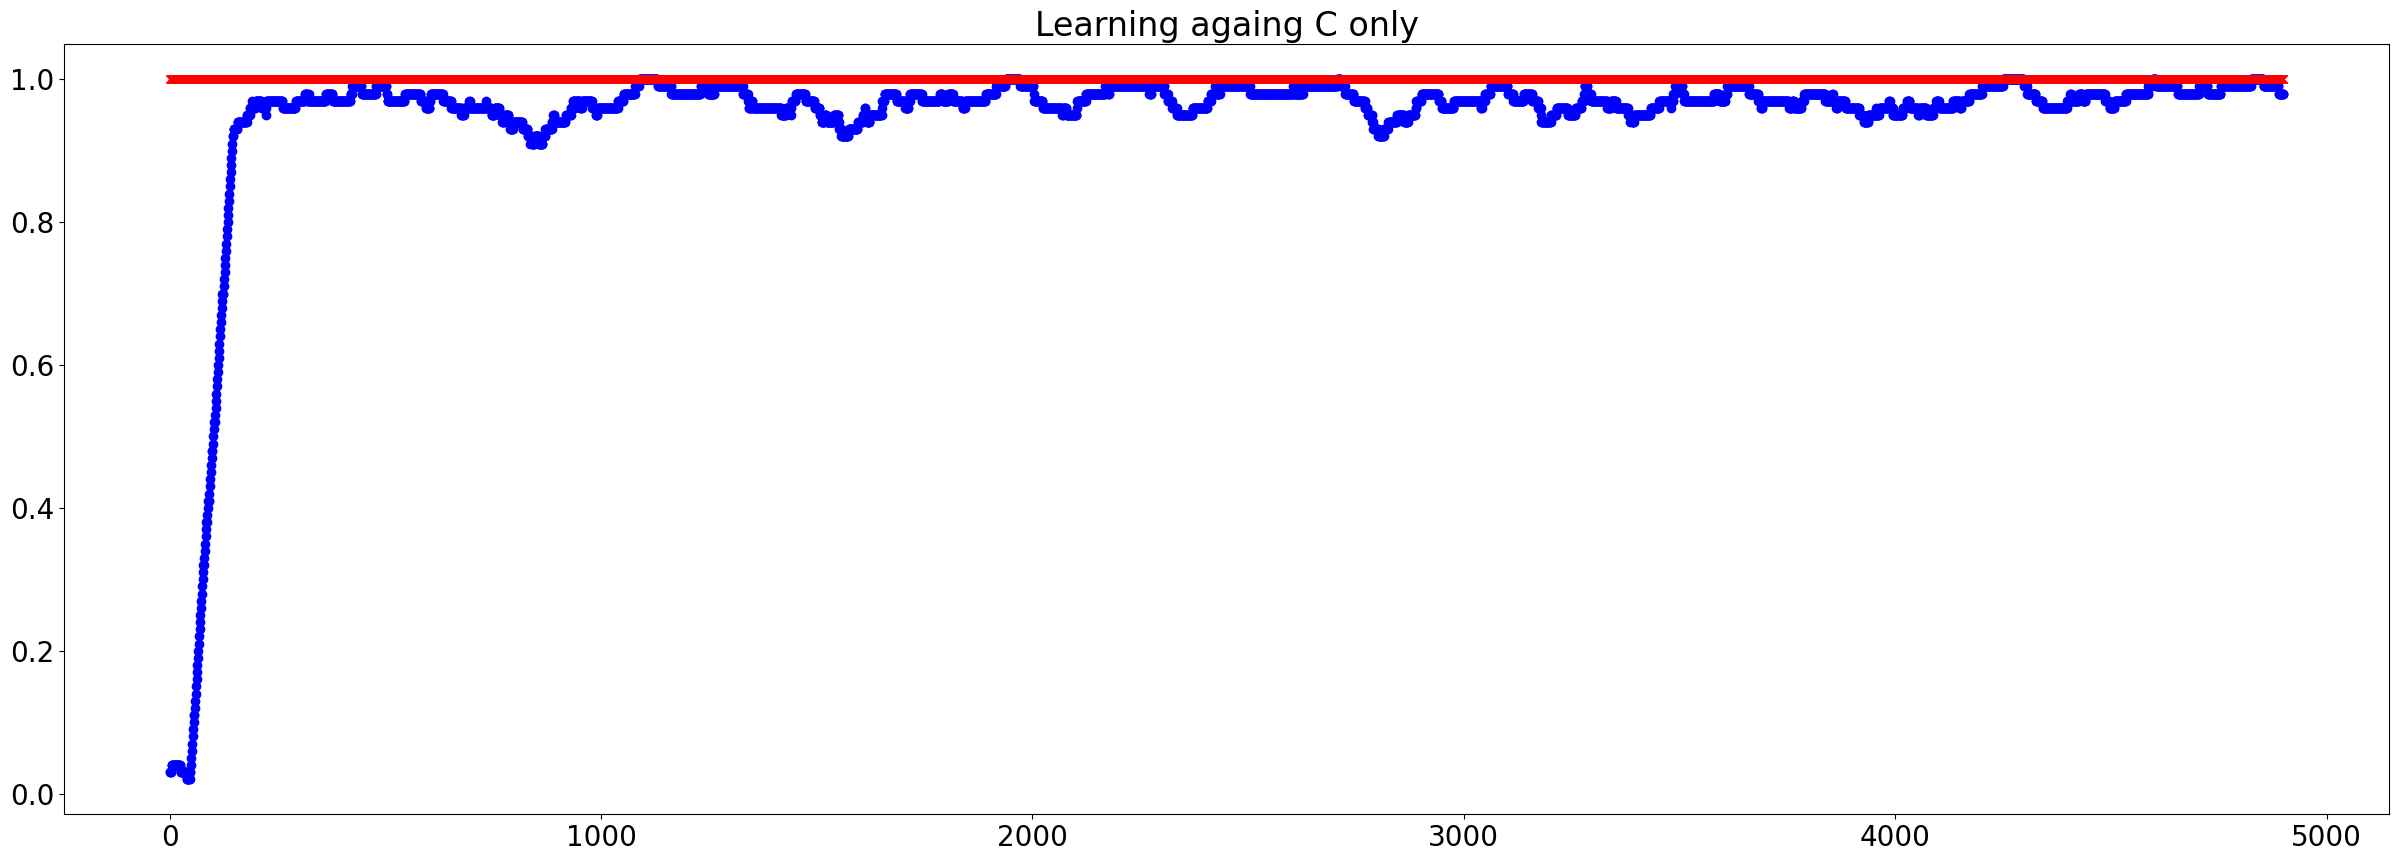

In [34]:
actions = np.array(actions)
plot(actions, 'Learning againg C only')

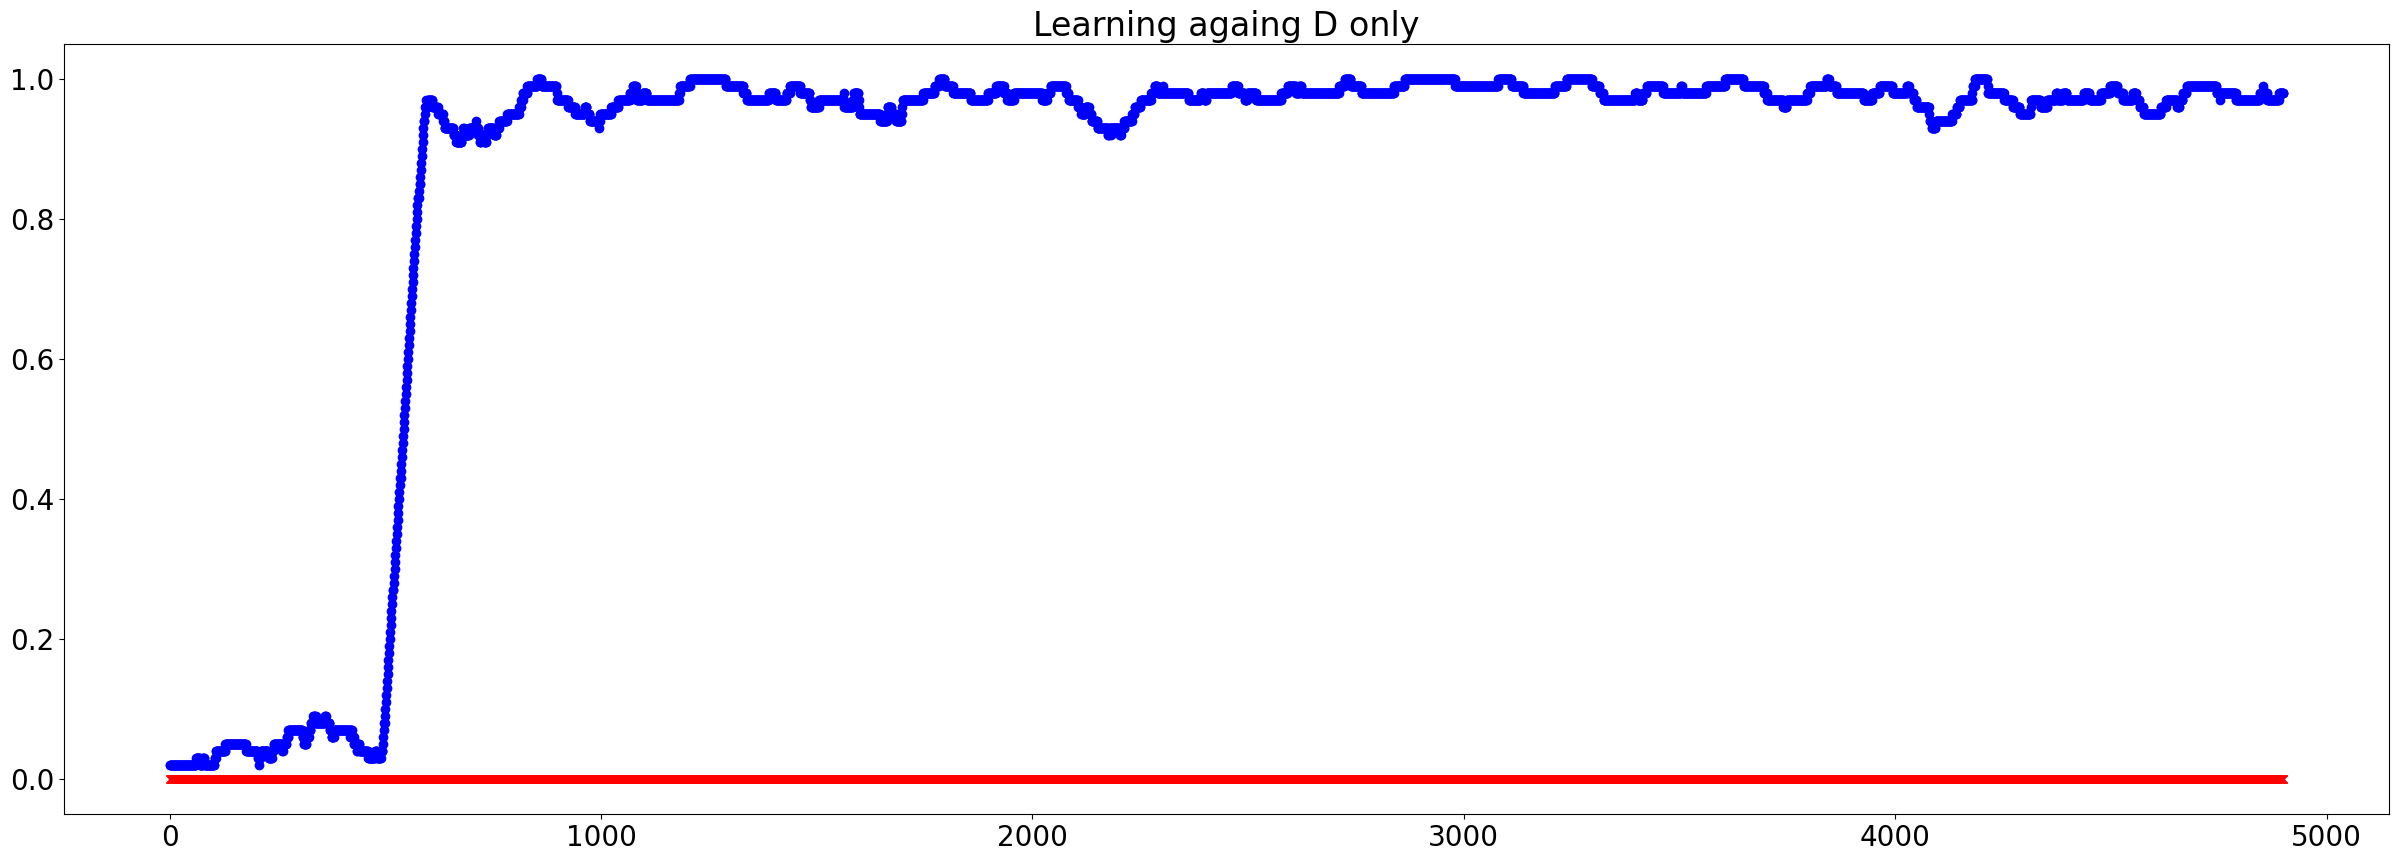

In [39]:
actions = np.array(actions)
plot(actions, 'Learning againg D only')

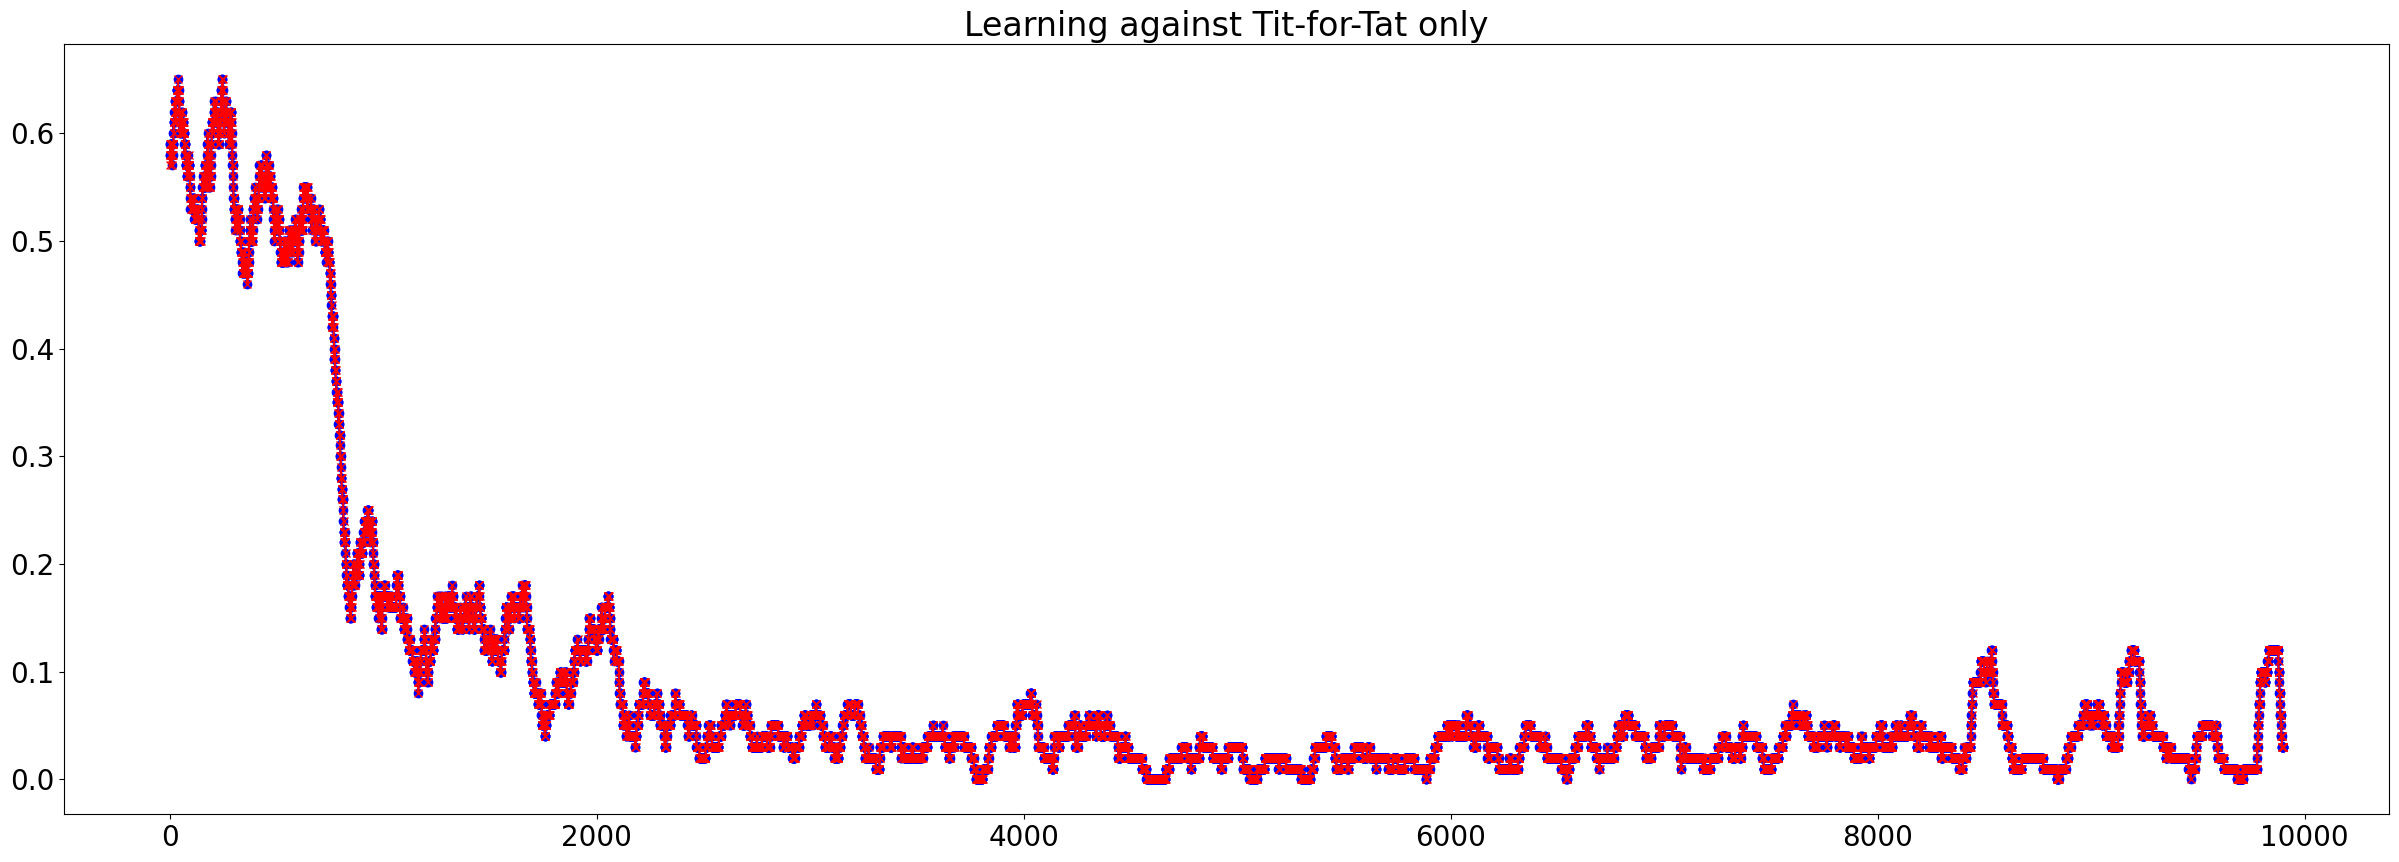

In [77]:
actions = np.array(actions)
plot(actions, 'Learning against Tit-for-Tat only')